In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

from custom_libs import db
from custom_libs import preprocessing
from custom_libs import classification
from custom_libs import dump
from custom_libs import plotting

from gensim.models import Word2Vec
import numpy as np

In [2]:
def transform_label_function(label):
    label = str(label)
    if label == "0":
        return classification.Sentiment.NEGATIVE
    elif label == "1":
        return classification.Sentiment.NEUTRAL
    elif label == "2":
        return classification.Sentiment.POSITIVE
    else:
       raise Exception(f"Invalid label: {label}")

In [3]:
x_column_name = "text"
x_column_cleaned_name = x_column_name + "_clean"
sentiment_column_name = "sentiment"

In [4]:
df = db.get_dataset("generic_sentiment_dataset")
df[sentiment_column_name] = df['label'].apply(transform_label_function)
df.head(5)

,sentiment,text,label
0,Positive,good mobile. battery is 5000 mah is very big. ...,2
1,Positive,Overall in hand ecpirience is quite good matt ...,2
2,Positive,"1. Superb Camera,\n2. No lag\n3. This is my fi...",2
3,Positive,Bigger size of application names doesn't allow...,2
4,Negative,Just a hype of stock android which is not flaw...,0


In [5]:
df = preprocessing.preprocess_df(df, x_column_name, x_column_cleaned_name)
df.head(10)

,sentiment,text,label,text_clean
0,Positive,good mobile. battery is 5000 mah is very big. ...,2,good mobile battery mah big camera quality good
1,Positive,Overall in hand ecpirience is quite good matt ...,2,overall hand ecpirience quite good matt finish...
2,Positive,"1. Superb Camera,\n2. No lag\n3. This is my fi...",2,superb camera lag first samsung phone earlier ...
3,Positive,Bigger size of application names doesn't allow...,2,big size application name allow name view full
4,Negative,Just a hype of stock android which is not flaw...,0,hype stock android flawless well custom ui lau...
5,Negative,First day mobile go to the conditions bad,0,first day mobile go condition bad
6,Neutral,Only for formal use its ok. If you want best c...,1,formal use ok want best camera sound quality i...
7,Negative,Battery Problem After 05 Month,0,battery problem month
8,Negative,"Confusing OS,Very low sound , worst camera qua...",0,confuse o low sound bad camera quality perform...
9,Neutral,Why its locked to indian Network only???\nI ca...,1,lock indian network use abroad useless trick s...


Accuracy of PassiveAggressiveClassifier is 0.6664444444444444
Accuracy of LogisticRegression is 0.7077222222222223
Accuracy of SVC is 0.7448888888888889
Accuracy: 0.7448888888888889
Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      5048
     Neutral       0.60      0.26      0.36      3517
    Positive       0.79      0.91      0.84      9435

    accuracy                           0.74     18000
   macro avg       0.70      0.65      0.65     18000
weighted avg       0.73      0.74      0.72     18000

Confusion matrix, without normalization


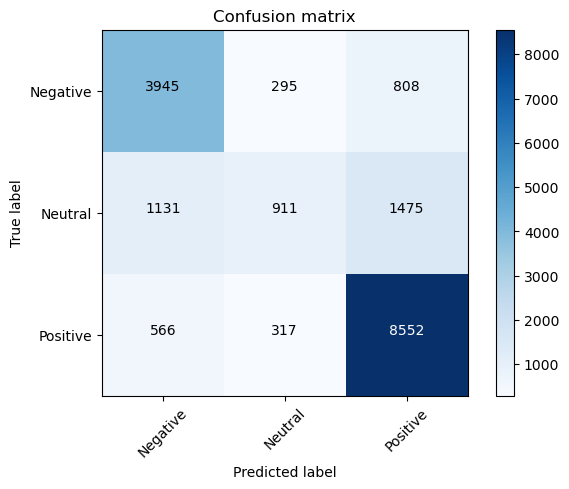

In [6]:
#test of word2vec
X, y = df[x_column_cleaned_name], df[sentiment_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, window=20, min_count=10, workers=4, sg=1)

#vectorization of sentences into training set and test set
X_train = np.array([classification.vectorize(sentence,w2v_model) for sentence in X_train])
X_test = np.array([classification.vectorize(sentence,w2v_model) for sentence in X_test])

#classification
clf = classification.select_best_classifier_from_accuracy([PassiveAggressiveClassifier,LogisticRegression,SVC],
                                     X_train, y_train, X_test, y_test)


#testing of the best model
y_pred= clf.predict(X_test)
class_names = classification.Sentiment.get_all()
classification.show_results(y_test, y_pred, class_names)


In [6]:
X, y = df[x_column_cleaned_name], df[sentiment_column_name]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy for PassiveAggressiveClassifier with vectorizer CountVectorizer - Max freq.=0.8 - Unigrams: 0.7553888888888889
Accuracy for PassiveAggressiveClassifier with vectorizer CountVectorizer - Max freq.=0.8 - From Unigrams to Bigrams: 0.8326111111111111
Accuracy for PassiveAggressiveClassifier with vectorizer CountVectorizer - Max freq.=0.8 - From Unigrams to Trigrams: 0.84


Accuracy for LogisticRegression with vectorizer CountVectorizer - Max freq.=0.8 - Unigrams: 0.7709444444444444
Accuracy for LogisticRegression with vectorizer CountVectorizer - Max freq.=0.8 - From Unigrams to Bigrams: 0.8411111111111111
Accuracy for LogisticRegression with vectorizer CountVectorizer - Max freq.=0.8 - From Unigrams to Trigrams: 0.8506111111111111


Accuracy for MultinomialNB with vectorizer CountVectorizer - Max freq.=0.8 - Unigrams: 0.7352222222222222
Accuracy for MultinomialNB with vectorizer CountVectorizer - Max freq.=0.8 - From Unigrams to Bigrams: 0.7847777777777778
Accuracy for Multinomia

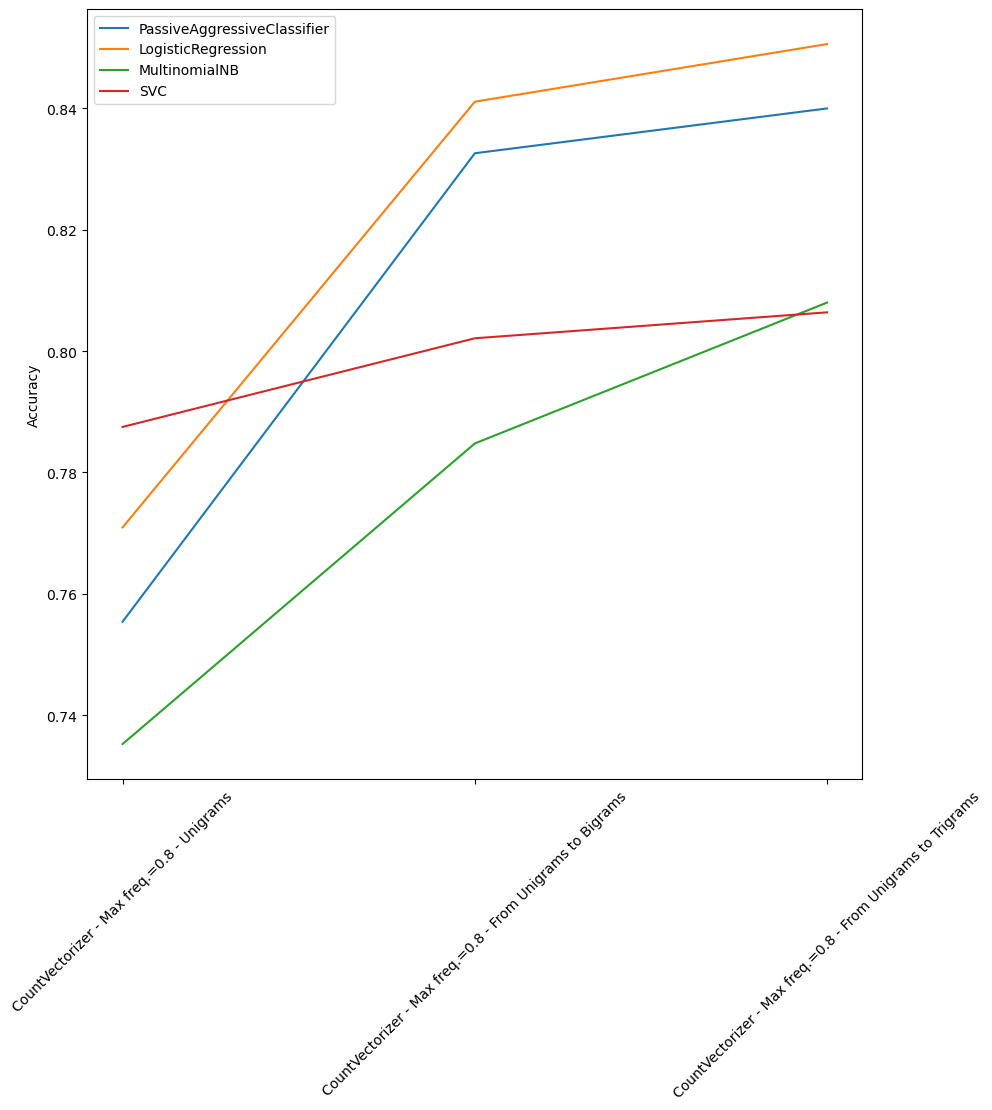

In [7]:
vectorizers = list()
vectorizers.append(CountVectorizer(stop_words='english', max_df=0.8,))
vectorizers.append(CountVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2)))
vectorizers.append(CountVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3)))

labels_vectorizers = [
    'CountVectorizer - Max freq.=0.8 - Unigrams', 
    'CountVectorizer - Max freq.=0.8 - From Unigrams to Bigrams', 
    'CountVectorizer - Max freq.=0.8 - From Unigrams to Trigrams',
    ]

models = [PassiveAggressiveClassifier, LogisticRegression, MultinomialNB, SVC]

results_accuracies = classification.test_classifiers(models, vectorizers, labels_vectorizers, x_train, x_test, y_train, y_test)

plotting.plot_accuracies(results_accuracies, labels_vectorizers)

Accuracy for PassiveAggressiveClassifier with vectorizer TfidfVectorizer - Max freq.=0.8 - Unigrams: 0.7680555555555556
Accuracy for PassiveAggressiveClassifier with vectorizer TfidfVectorizer - Max freq.=0.8 - From Unigrams to Bigrams: 0.8379444444444445
Accuracy for PassiveAggressiveClassifier with vectorizer TfidfVectorizer - Max freq.=0.8 - From Unigrams to Trigrams: 0.8441111111111111


Accuracy for LogisticRegression with vectorizer TfidfVectorizer - Max freq.=0.8 - Unigrams: 0.7581666666666667
Accuracy for LogisticRegression with vectorizer TfidfVectorizer - Max freq.=0.8 - From Unigrams to Bigrams: 0.8027777777777778
Accuracy for LogisticRegression with vectorizer TfidfVectorizer - Max freq.=0.8 - From Unigrams to Trigrams: 0.8116111111111111


Accuracy for MultinomialNB with vectorizer TfidfVectorizer - Max freq.=0.8 - Unigrams: 0.7203333333333334
Accuracy for MultinomialNB with vectorizer TfidfVectorizer - Max freq.=0.8 - From Unigrams to Bigrams: 0.7247777777777777
Accuracy 

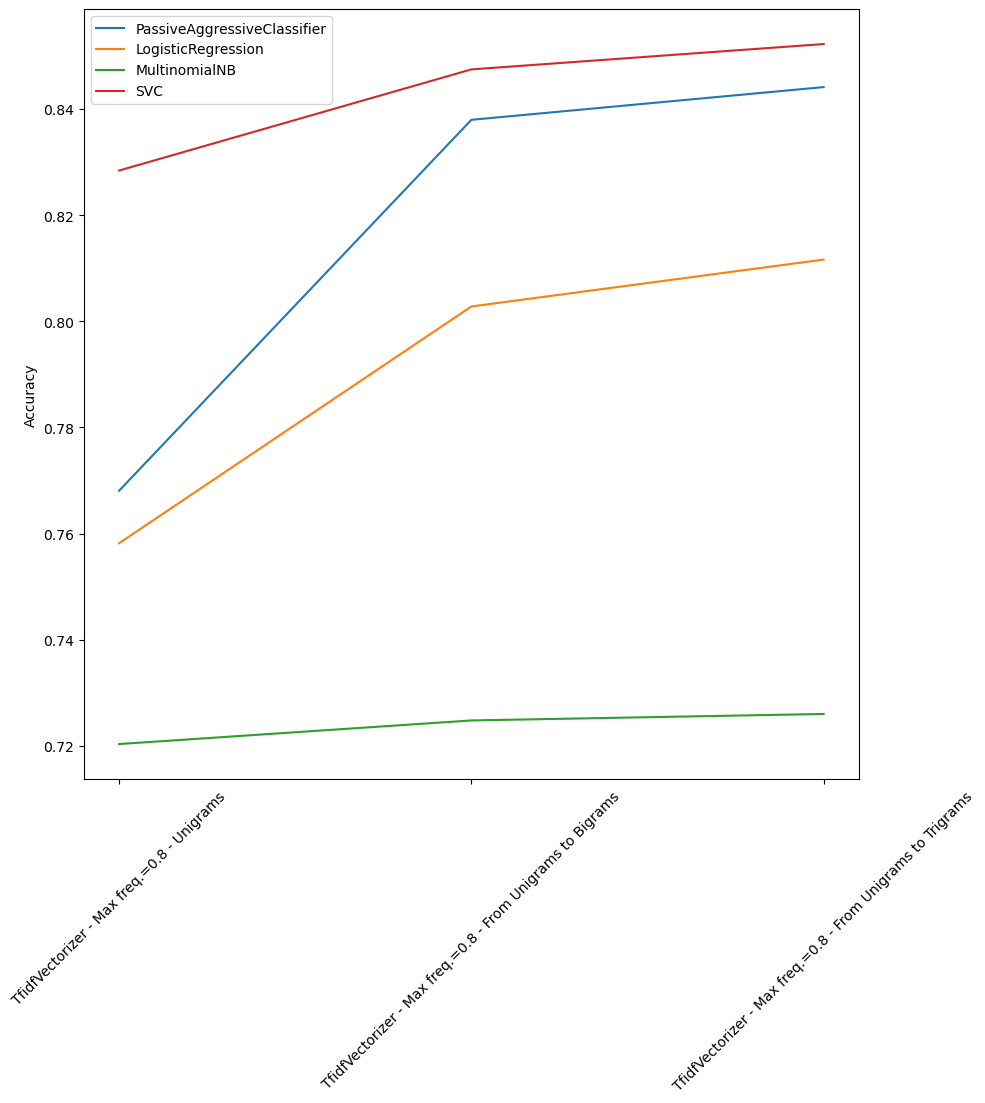

In [8]:
vectorizers = list()
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8,))
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2)))
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3)))

labels_vectorizers = [
    'TfidfVectorizer - Max freq.=0.8 - Unigrams', 
    'TfidfVectorizer - Max freq.=0.8 - From Unigrams to Bigrams', 
    'TfidfVectorizer - Max freq.=0.8 - From Unigrams to Trigrams',
    ]

models = [PassiveAggressiveClassifier, LogisticRegression, MultinomialNB, SVC]

results_accuracies = classification.test_classifiers(models, vectorizers, labels_vectorizers, x_train, x_test, y_train, y_test)

plotting.plot_accuracies(results_accuracies, labels_vectorizers)

Accuracy: 0.8522222222222222
Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.87      0.85      5048
     Neutral       0.84      0.57      0.68      3517
    Positive       0.87      0.95      0.90      9435

    accuracy                           0.85     18000
   macro avg       0.85      0.80      0.81     18000
weighted avg       0.85      0.85      0.85     18000

Confusion matrix, without normalization


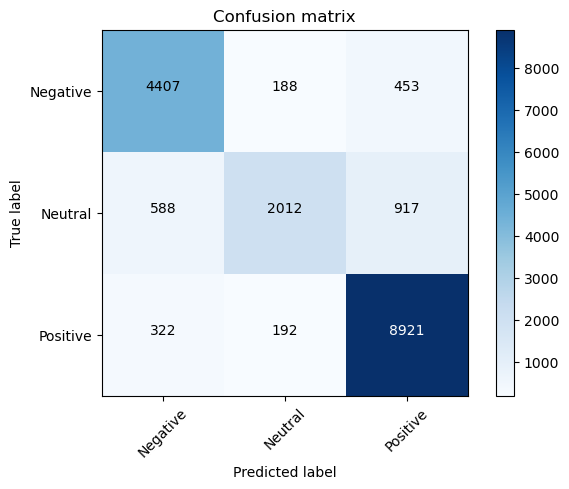

In [9]:
# Best combination of model and vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
x_train_trasformed = vectorizer.fit_transform(x_train)
x_test_trasformed = vectorizer.transform(x_test)

class_names = classification.Sentiment.get_all()
model = SVC()
model.fit(x_train_trasformed, y_train)
y_pred = model.predict(x_test_trasformed)
classification.show_results(y_test, y_pred, class_names)

In [10]:
# dump.save_model(model, "our_model")
# dump.save_vectorizer(vectorizer, "our_vectorizer")